# Estimate rates: Regular

In [12]:
import numpy as np
import matplotlib.pylab as plt
import random
from scipy.special import comb

import sys
sys.path.append('../src/')
sys.path.append('../scripts/')

from simulate_gillespie import *
from estimate_total_rates import *

from generators_hg_test import random_regular_hypergraph
from higher_order_structures import HigherOrderStructure

## Setup

In [34]:
n = 1000
d1, d2 = 9, 3

In [14]:
edges, triangles = random_regular_hypergraph(d1, d2, n)

print(f"\nRegular-HG on {n} nodes.")
print(f"number of 2-node edges: {len(edges)}")
print(f"number of 3-node edges: {len(triangles)}")


Regular-HG on 1000 nodes.
number of 2-node edges: 4500
number of 3-node edges: 1000


In [15]:
all_edges = []
for edge in list(edges) + list(triangles):
    if len(edge) == 2:
        u, v = edge
        all_edges.append((int(u), int(v)))
    if len(edge) == 3:
        u, v, w = edge
        all_edges.append((int(u), int(v), int(w)))

In [16]:
all_edges[:5], all_edges[-5:]

([(0, 842), (0, 657), (0, 228), (0, 846), (0, 262)],
 [(416, 751, 783),
  (389, 534, 693),
  (693, 719, 810),
  (127, 319, 534),
  (171, 657, 751)])

In [17]:
N = 1000
max_i = 0
for edge in all_edges:
    if max(edge) > max_i:
        max_i = max(edge)
max_i, N

(999, 1000)

In [18]:
g = HigherOrderStructure(N)
g.set_edges(all_edges)
g.name = f"Regular-HG"
g.print()

	Regular-HG on 1000 nodes with 5500 edges.



In [19]:
# g.summary() # TODO could add some properties to attributes
pw_degrees_sc = np.zeros(N, dtype=int)
ho_degrees_sc = np.zeros(N, dtype=int)

for i in range(N):
    pw_degrees_sc[i] = len(g.neighbors(i, 1))
    ho_degrees_sc[i] = len(g.neighbors(i, 2))

realized_avg_pw = np.mean(pw_degrees_sc)
realized_avg_ho = np.mean(ho_degrees_sc)

d1, d2 = realized_avg_pw, realized_avg_ho
d1, d2 = int(d1), int(d2)
d1, d2

(9, 3)

In [20]:
test_name = "regular"

I0 = 50
nsims = 100

run_gillespie_simulations = True
time_max = 10

In [21]:
# set beta1, beta2 such that k^* = .75 N
mu    = 1             # recovery rate

# TODO: 
# Try with 
# lambda_1 \in [1, 1.3, 1.5]
# lambda_2 \in [2, 5]
lambda1 = 1.6 # <- increase lambda
lambda2 = 4

beta1 = lambda1 * mu / d1 # pairwise infection rate
beta2 = lambda2 * mu / d2 # hyperedge contagion rate

# g.summary()

print(f"{test_name}: \n")
print(f"\tH = {g.name}, N = {N}, (d1, d2) = {(d1, d2)}, I0 = {I0}, time_max = {time_max},")
g.print()

print(f"\tbeta1 = {beta1:.4f}, beta2 = {beta2:.4f}")
print(f"\twith estimation based on {nsims} Gillespie simulation runs\n")

regular: 

	H = Regular-HG, N = 1000, (d1, d2) = (9, 3), I0 = 50, time_max = 10,
	Regular-HG on 1000 nodes with 5500 edges.

	beta1 = 0.1778, beta2 = 1.3333
	with estimation based on 100 Gillespie simulation runs



## Run Gillespie

exited on time=10.000636345400013, waiting_time=0.0013969877692206994
exited on time=10.000358468810001, waiting_time=0.002114783389994749
exited on time=10.000239895556426, waiting_time=0.0007928095666315629
exited on time=10.000274316981454, waiting_time=0.0006690060387995331
exited on time=10.0008353216485, waiting_time=0.0011635308138868209
exited on time=10.000290348788985, waiting_time=0.0007225420984482453
exited on time=10.001730563116269, waiting_time=0.0028974421107883213
exited on time=10.000404177820792, waiting_time=0.0012167005946016466
exited on time=10.000097171386974, waiting_time=0.0007680964179627295
exited on time=10.00023505918716, waiting_time=0.0002457130733848074
exited on time=10.000681286330256, waiting_time=0.0011990256319674363
exited on time=10.001148849948601, waiting_time=0.001335520465277139
exited on time=10.00170961082298, waiting_time=0.002323487692857684
exited on time=10.000447309558476, waiting_time=0.0005330429473088703
exited on time=10.000459251

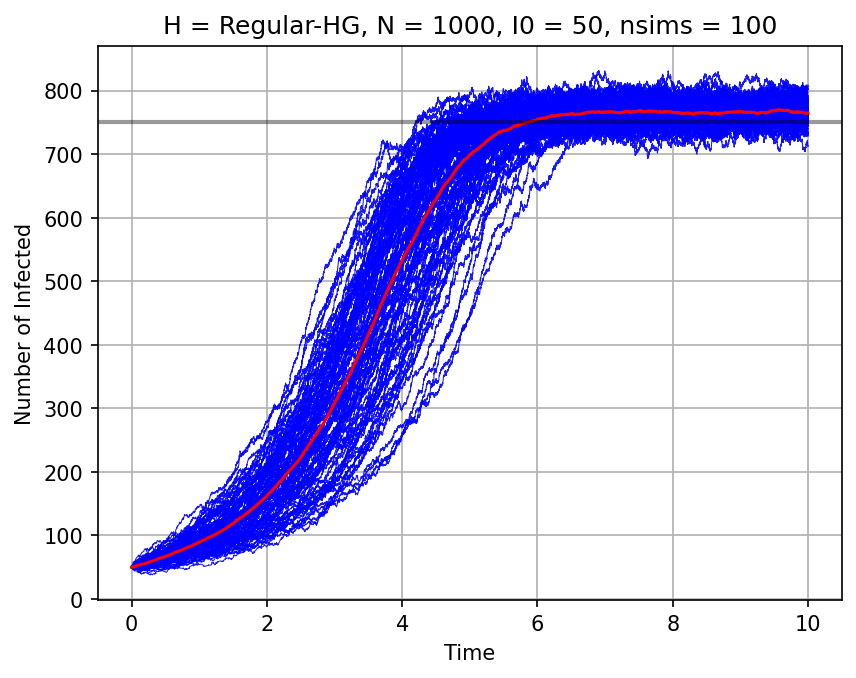

In [22]:
## --- Run Gillespie ---
run_gillespie_simulations = True

I0_gillespie = I0 # TODO: go over the range when necessary
nodes = list(g.nodes.keys())
initial_infections = random.sample(nodes, I0)

if run_gillespie_simulations: 
    X_sims = []
    for _ in range(nsims):
        X_t = gillespie_sim(g, beta1, beta2, mu, initial_infections, time_max)
        X_sims.append(X_t)

    # save the simulation results
    sim_results = {f'sim_{i}': X_sims[i] for i in range(nsims)}
    np.savez_compressed(f'../results/gillespie-sims_{test_name}_I0={I0}.npz', **sim_results)
else: 
    # load simulation results
    sim_results = np.load(f'../results/gillespie-sims_{test_name}_I0={I0}.npz', allow_pickle=True)
    X_sims = [sim_results[f'sim_{i}'] for i in range(nsims)]

# plot X_t curves in gray and average curve in red
fig = plt.figure(dpi=150) # set DPI
ax  = plt.subplot()

for X_t in X_sims:
    ax.plot(X_t[0], X_t[2], c="blue", alpha=0.9, linewidth=0.5, rasterized=True)

avg_curve, times = get_average(X_sims, time_max, nsims, delta_t = 0.01)
plt.plot(times, avg_curve, "red")

plt.axhline(y=int(0.75 * N), color='black', lw=2, alpha=0.4, linestyle='-')

plt.xlabel("Time")
plt.ylabel("Number of Infected")
plt.grid(True)
plt.title(f"H = {g.name}, N = {N}, I0 = {I0}, nsims = {nsims}")
plt.savefig(f"../figures/estimation/{test_name}/gillespie-sims.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()
plt.close(fig) # free up memory

## Solve KEs and compare

In [23]:
d1, d2

(9, 3)

In [24]:
target_p1 = d1 / (N - 1.0)
target_p2 = (2.0 * d2) / ((N - 1.0) * (N - 2.0))
target_p1, target_p2

(0.009009009009009009, 6.018042090186378e-06)

In [25]:
target_p1 = d1 / (N - 1.0)
target_p2 = (2.0 * d2) / ((N - 1.0) * (N - 2.0))

# solve KEs and compare
all_states = list(range(N + 1))
M = len(all_states)
# ode_system_complete = list_all_ODEs_complete(g, beta1, beta2, mu)
ode_system_random = list_all_ODEs_random(g, beta1, beta2, mu, target_p1, target_p2)

# set the initial condition
p0 = np.zeros(M)
i_set0 = all_states.index(I0)
p0[i_set0] = 1.0 # all other states have prob 0 at time 0
# p0

## Calculate the estimates

In [26]:
## --- Calculate the estimates ---
min_Tk_threshold = 1e-6
# estimates = calculate_estimates(X_sims_aligned, N, min_Tk_threshold)
estimates = calculate_estimates(X_sims, N, min_Tk_threshold)

Total events processed: 1123029


In [27]:
np.mean(estimates["a_k_hat"], axis=0), np.nanmean(estimates["a_k_hat"], axis=0)

(np.float64(232.91590856426845), np.float64(232.91590856426845))

In [28]:
target_p1, target_p2

(0.009009009009009009, 6.018042090186378e-06)

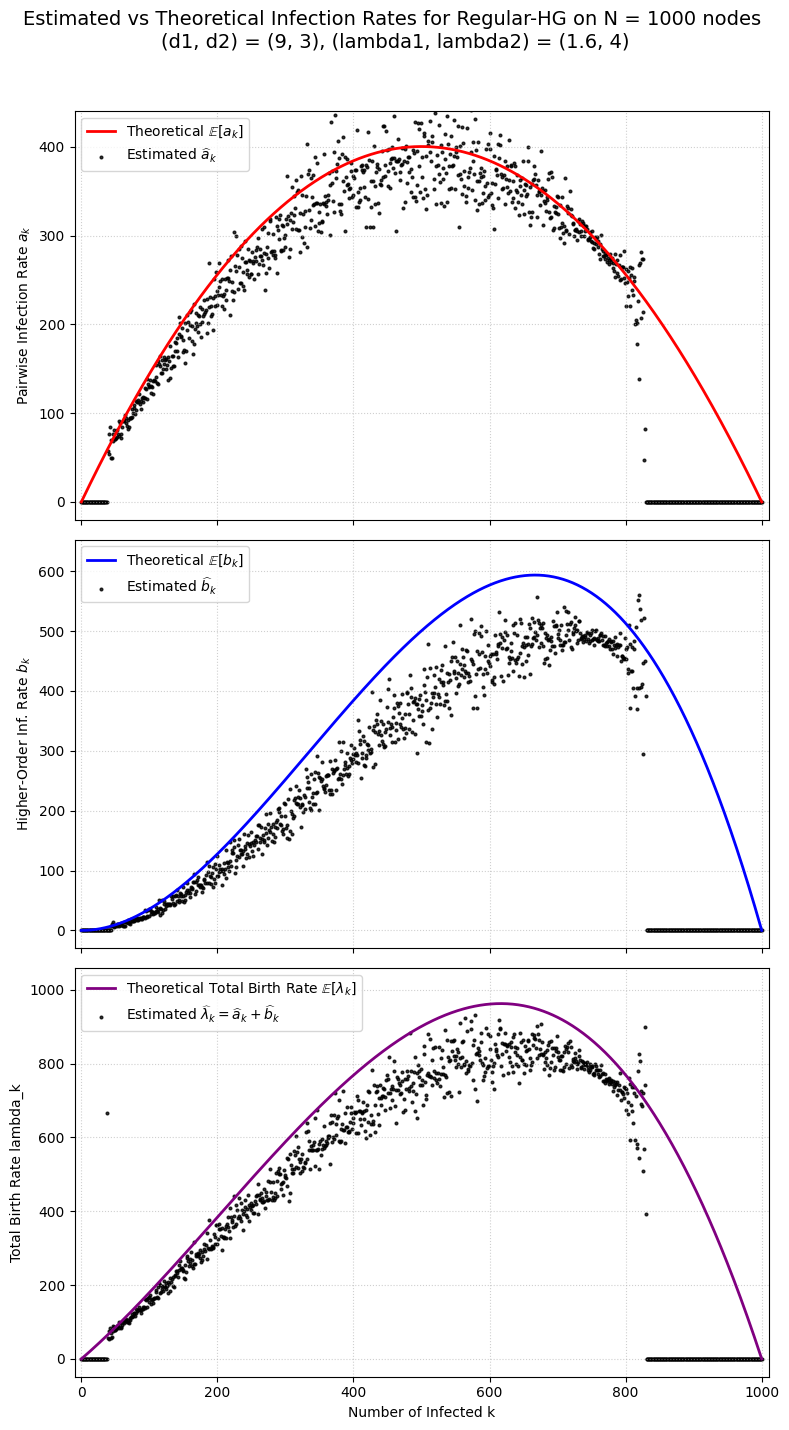

In [33]:
ak_hat_point_estimates = estimates["a_k_hat"]
bk_hat_point_estimates = estimates["b_k_hat"]
lambda_k_hat_point_estimates = estimates["lambda_k_hat"]

plot_valid_k_idx = ~np.isnan(ak_hat_point_estimates)

# theoretical (expected) rates for ER-SC
k_values = np.arange(N + 1)
k_choose_2 = np.array([comb(k, 2, exact=True) if k >= 2 else 0 for k in k_values], dtype=float)
a_k_theoretical = beta1 * target_p1 * k_values * (N - k_values)
b_k_theoretical = beta2 * target_p2 * k_choose_2 * (N - k_values)
total_birth_k_theoretical = a_k_theoretical + b_k_theoretical

fig, axes = plt.subplots(3, 1, figsize=(8, 15), sharex=True)
title = f"Estimated vs Theoretical Infection Rates for {g.name} on N = {N} nodes \n"
title += f"(d1, d2) = ({d1}, {d2}), (lambda1, lambda2) = ({lambda1}, {lambda2})"
fig.suptitle(title, fontsize=14)

# PW rates a_k
axes[0].plot(k_values, a_k_theoretical, color="red", linestyle='-', linewidth=2,
             label=r'Theoretical $\mathbb{E}[a_k]$')
axes[0].scatter(k_values[plot_valid_k_idx], ak_hat_point_estimates[plot_valid_k_idx],
                color="black", marker='.', s=15, alpha=0.8,
                label=r'Estimated $\widehat{a}_k$')
axes[0].set_ylabel("Pairwise Infection Rate $a_k$")
axes[0].legend(loc='upper left')
axes[0].grid(True, linestyle=':', alpha=0.6)

min_y_ak = np.nanmin(ak_hat_point_estimates[plot_valid_k_idx]) if np.any(plot_valid_k_idx) else 0
max_y_ak_theory = np.nanmax(a_k_theoretical)
axes[0].set_ylim(bottom=min(0, min_y_ak) - 0.05 * max_y_ak_theory,
                 top=max_y_ak_theory * 1.1 if max_y_ak_theory > 0 else 0.1)


# HO rates b_k
axes[1].plot(k_values, b_k_theoretical, color="blue", linestyle='-', linewidth=2,
             label=r'Theoretical $\mathbb{E}[b_k]$')
axes[1].scatter(k_values[plot_valid_k_idx], bk_hat_point_estimates[plot_valid_k_idx],
                color="black", marker='.', s=15, alpha=0.8,
                label=r'Estimated $\widehat{b}_k$')
axes[1].set_ylabel("Higher-Order Inf. Rate $b_k$")
axes[1].legend(loc='upper left')
axes[1].grid(True, linestyle=':', alpha=0.6)
min_y_bk = np.nanmin(bk_hat_point_estimates[plot_valid_k_idx]) if np.any(plot_valid_k_idx) else 0
max_y_bk_theory = np.nanmax(b_k_theoretical)
axes[1].set_ylim(bottom=min(0, min_y_bk) - 0.05 * max_y_bk_theory,
                 top=max_y_bk_theory * 1.1 if max_y_bk_theory > 0 else 0.1)


# total birth rates lambda_k = a_k + b_k
axes[2].plot(k_values, total_birth_k_theoretical, color="purple", linestyle='-', linewidth=2,
             label=r'Theoretical Total Birth Rate $\mathbb{E}[\lambda_k]$')
axes[2].scatter(k_values[plot_valid_k_idx], lambda_k_hat_point_estimates[plot_valid_k_idx],
                color="black", marker='.', s=15, alpha=0.8,
                label=r'Estimated $\widehat{\lambda}_k = \widehat{a}_k + \widehat{b}_k$')
axes[2].set_ylabel("Total Birth Rate lambda_k")
axes[2].legend(loc='upper left')
axes[2].grid(True, linestyle=':', alpha=0.6)
min_y_lk = np.nanmin(lambda_k_hat_point_estimates[plot_valid_k_idx]) if np.any(plot_valid_k_idx) else 0
max_y_lk_theory = np.nanmax(total_birth_k_theoretical)
axes[2].set_ylim(bottom=min(0, min_y_lk) - 0.05 * max_y_lk_theory,
                 top=max_y_lk_theory * 1.1 if max_y_lk_theory > 0 else 0.1)


axes[2].set_xlabel("Number of Infected k")
for ax_item in axes:
    ax_item.set_xlim(left=-N*0.01, right=N*1.01)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.savefig(f"../figures/estimation/{test_name}/supporting_fig_rates.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()
plt.close(fig)

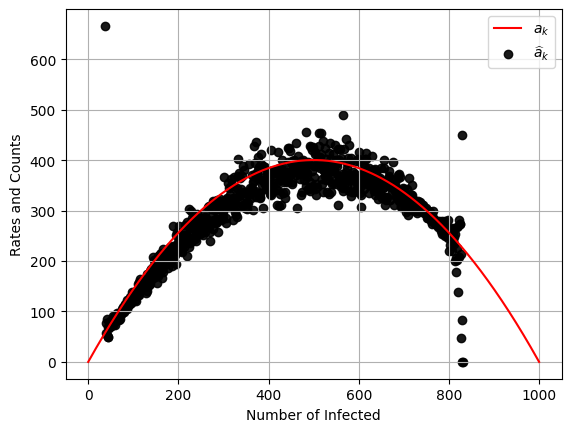

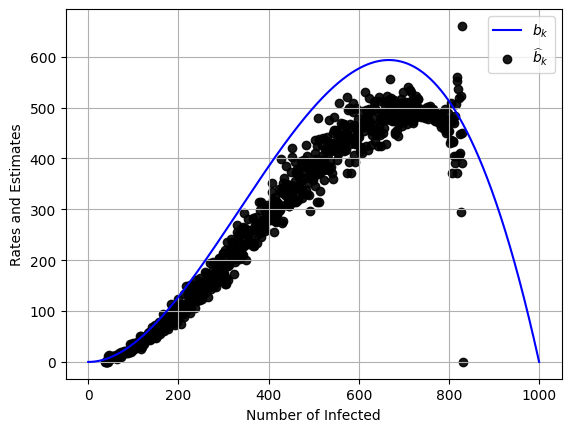

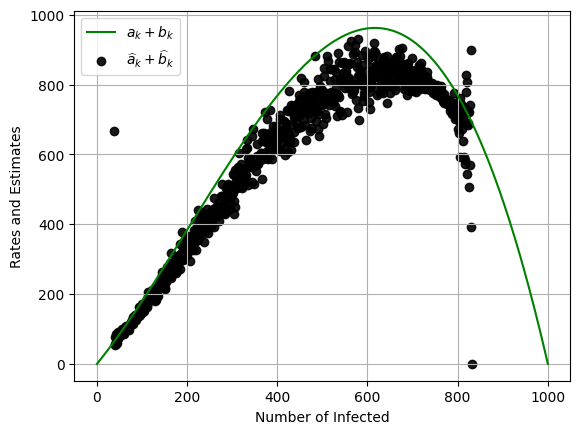

In [30]:
a_k_hat = estimates["a_k_hat"]
b_k_hat = estimates["b_k_hat"]
c_k_hat = estimates["c_k_hat"]

# plot only where T_k was non-zero!
valid_k_idx = estimates["T_k"] > min_Tk_threshold   

# and compare them to theoretical rates
k_values = np.arange(0, N + 1) # number of infected from 0 to N
k_choose_2 = np.array(list(map(lambda k: comb(k, 2, exact=True), k_values)))

# TODO: what are theoretical rates now?
a_k = target_p1 * beta1 * k_values * (N - k_values)
b_k = target_p2 * beta2 * k_choose_2 * (N - k_values)

# TODO: replace c_k with sum lambda_k = birth_rate_k = a_k + b_k
c_k = mu * k_values

fig = plt.figure()
ax = plt.subplot()

# theoretical ak vs. ak hats 
ax.plot(k_values, a_k, label=r'$a_k$', color="red")
ax.scatter(k_values[valid_k_idx], a_k_hat[valid_k_idx],
        label=r'$\widehat{a}_k$', color="black", alpha=0.9)
plt.xlabel("Number of Infected")
plt.ylabel("Rates and Counts")
plt.legend()
plt.grid(True)    
plt.savefig(f"../figures/estimation/{test_name}/estimates_ak.pdf", 
            format='pdf', bbox_inches='tight')    
plt.show()

# theoretical bk vs. bk hats
fig = plt.figure()
ax = plt.subplot()
ax.plot(k_values, b_k, label=r'$b_k$', color="blue")
ax.scatter(k_values[valid_k_idx], b_k_hat[valid_k_idx],
        label=r'$\widehat{b}_k$', color="black", alpha=0.9)
plt.xlabel("Number of Infected")
plt.ylabel("Rates and Estimates")
plt.legend()
plt.grid(True)    
plt.savefig(f"../figures/estimation/{test_name}/estimates_bk.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()

# theoretical ck vs. ck hats (as a test only)
fig = plt.figure()
ax = plt.subplot()
ax.plot(k_values, a_k + b_k, label=r'$a_k + b_k$', color="green")
ax.scatter(k_values[valid_k_idx], a_k_hat[valid_k_idx] + b_k_hat[valid_k_idx],
        label=r'$\widehat{a}_k + \widehat{b}_k$', color="black", alpha=0.9)
plt.xlabel("Number of Infected")
plt.ylabel("Rates and Estimates")
plt.legend()
plt.grid(True)
plt.savefig(f"../figures/estimation/{test_name}/estimates_ck.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()

## Solve KEs using the estimates

In [31]:
## --- Solve KEs using the estimates and compare ---
# --- Model 2 ---

# solve ode_system_random over time
t_span = (0.0, time_max)

# times t_i to evaluate in, get saved in sol.t
steps_eval = 202
t_eval = np.linspace(t_span[0], t_span[1], steps_eval)

ode_system = list_all_ODEs_using_estimates(g, a_k_hat, b_k_hat, mu)

def f_ode(t, p):
    return ode_system(t, p)


all_states = list(range(N + 1))
M = len(all_states)

p0 = np.zeros(M)
i_set0 = all_states.index(I0)
p0[i_set0] = 1.0 # all other states have prob 0 at time 0

sol_hat = solve_ivp(f_ode, 
                    t_span, 
                    p0, 
                    t_eval=t_eval,
                    method="LSODA")

expected_values_hat = calculate_expected_values(sol_hat)

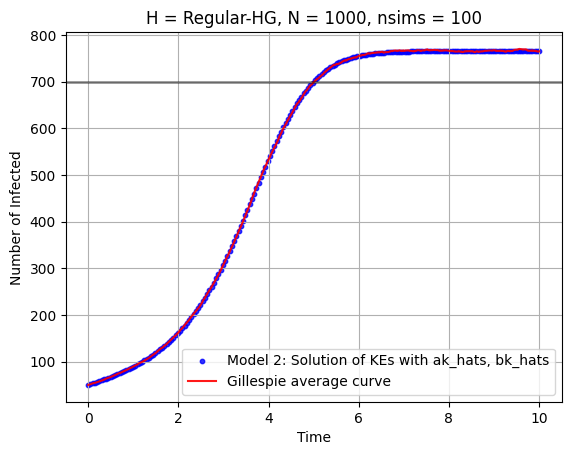

In [32]:
plt.figure()

# plt.plot(sol.t, expected_values_hat, color="b", label="Model 2: Solution of KEs with ak_hats, bk_hats")
plt.scatter(sol_hat.t, expected_values_hat, color="b", s=10, alpha=.8, label="Model 2: Solution of KEs with ak_hats, bk_hats")

plt.plot(times, avg_curve, 'red', label="Gillespie average curve", alpha=0.9)

plt.axhline(y=int(0.7 * N), color='black', lw=2, alpha=0.4, linestyle='-')

plt.xlabel("Time")
plt.ylabel("Number of Infected")
plt.legend()
plt.grid(True)
plt.title(f"H = {g.name}, N = {N}, nsims = {nsims}")
plt.savefig(f"../figures/estimation/{test_name}/solutions-comparison.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()